In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import seaborn as sns; sns.set()
import statsmodels.formula.api as smf
import patsy
from scipy import stats
from sklearn import datasets
from IPython.display import display, HTML
from ISLP import load_data

In [44]:
#(8)
auto_df = pd.read_csv('../Ch2/Auto.csv')

# Remove missing values
auto_df = auto_df.drop(auto_df[auto_df.values == '?'].index)
auto_df = auto_df.reset_index()
auto_df.head()

,index,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [45]:
# Convert quantitive datatypes to numerics
datatypes = {'quant': ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'],
             'qual': ['origin', 'name']}
quants = auto_df[datatypes['quant']].astype(np.float_)
auto_df = pd.concat([quants, auto_df[datatypes['qual']]], axis=1) 
auto_df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4.0,140.0,86.0,2790.0,15.6,82.0,1,ford mustang gl
388,44.0,4.0,97.0,52.0,2130.0,24.6,82.0,2,vw pickup
389,32.0,4.0,135.0,84.0,2295.0,11.6,82.0,1,dodge rampage
390,28.0,4.0,120.0,79.0,2625.0,18.6,82.0,1,ford ranger


In [46]:
#linear regression using numpy linear algebra
intercept_const = pd.DataFrame({'intercept': np.ones(auto_df.shape[0])})

X = pd.concat([intercept_const, auto_df['horsepower']], axis=1)
y = auto_df['mpg']
def linear_model(X, y):
    """Estimation of parameteres for linear regressions model by Ordinary Least Squares (OLS)"""
    XTX_inv = np.linalg.inv(X.T @ X)
    XTy     = X.T @ y
    beta    = XTX_inv @ XTy
    return beta

def predict(beta, X):
    """Perdict y given beta parameters and X variables"""
    return X @ beta

beta = linear_model(X, y)
y_pred = predict(beta, X)

In [47]:
# For each estimated coefficient we would like to get the follow stats
# - coefficient 
# - standard error
# - t-value
# - p-value

# Add constant for bias variable
intercept_const = pd.DataFrame({'intercept': np.ones(auto_df.shape[0])})
#Load data
X = pd.concat([intercept_const, auto_df['horsepower']], axis=1)
y = auto_df['mpg']

# Predict coefficients and responses
coefficients = linear_model(X, y)
y_pred = predict(beta, X)

# Calculate Mean Squared Error
MSE = np.sum(np.square(y_pred - y)) / y.size

# Variance of each variable in X
variance = MSE * (np.linalg.inv(X.T @ X).diagonal())

# Standard error of each variable in X
# given by Var(X) = SE(X)^2
standard_error = np.sqrt(variance)

# t-statistic given by t = β - 0 / SE(β)
t_statistic = coefficients / standard_error

# p-values
p_values = 2*(1 - stats.t.cdf(X.shape[0], np.abs(t_statistic)))

# Present results
results = pd.DataFrame({'feature': X.columns,
                        'coefficients': coefficients,
                        'standard_error': standard_error,
                        't-statistic': t_statistic,
                        'P>|t|': p_values})

results.set_index('feature')

,coefficients,standard_error,t-statistic,P>|t|
feature,,,,
intercept,39.935861,0.715666,55.802376,0.0
horsepower,-0.157845,0.006429,-24.551848,0.0


In [48]:
# The statsmodels library provides a convenient means to get the
# same statistics

X = auto_df['horsepower']
X = sm.add_constant(X)     # add bias constant
y = auto_df['mpg']

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           7.03e-81
Time:                        13:27:42   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

In [49]:
"""
i. Is there a relationship between the predictor and the response?
Yes, the low P-value associated with the t-statistic for horsepower suggests so.

ii. How strong is the relationship between the predictor and the response?
For a unit increase in horsepower, our model predicts mpg will decrease by -0.1578. So for example, 
increasing horsepower by 10 is expected to decrease efficiency by -1.578 mpg.

iii. Is the relationship between the predictor and the response positive or negative?
Negative
"""

'\ni. Is there a relationship between the predictor and the response?\nYes, the low P-value associated with the t-statistic for horsepower suggests so.\n\nii. How strong is the relationship between the predictor and the response?\nFor a unit increase in horsepower, our model predicts mpg will decrease by -0.1578. So for example, \nincreasing horsepower by 10 is expected to decrease efficiency by -1.578 mpg.\n\niii. Is the relationship between the predictor and the response positive or negative?\nNegative\n'

In [50]:
# (iv)
# predicted mpg associated with a horsepower of 98
def predict(model, X):
    return model @ X

X_ex = np.array([1, 98])

y_ex = predict(coefficients, X_ex)
print(str(np.round(y_ex, 3)) + ' mpg')

24.467 mpg


In [51]:
model_min = results.conf_int(alpha=0.05)[0]
model_max = results.conf_int(alpha=0.05)[1]

confidence_interval = [predict(model_min, X_ex), predict(model_max, X_ex)]
print(confidence_interval)

[21.81454495972265, 27.11960934530221]


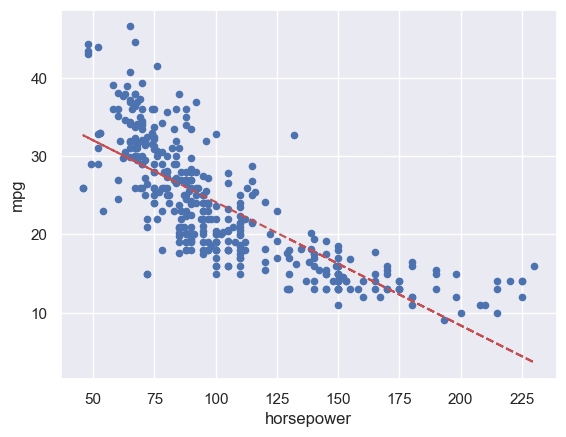

In [52]:
df = pd.concat([auto_df['horsepower'], auto_df['mpg']], axis=1)
ax = df.plot.scatter('horsepower','mpg')
ax.plot(auto_df['horsepower'],y_pred,'r--')

array([[<Axes: xlabel='mpg', ylabel='mpg'>,
        <Axes: xlabel='cylinders', ylabel='mpg'>,
        <Axes: xlabel='displacement', ylabel='mpg'>,
        <Axes: xlabel='horsepower', ylabel='mpg'>,
        <Axes: xlabel='weight', ylabel='mpg'>,
        <Axes: xlabel='acceleration', ylabel='mpg'>,
        <Axes: xlabel='year', ylabel='mpg'>,
        <Axes: xlabel='origin', ylabel='mpg'>],
       [<Axes: xlabel='mpg', ylabel='cylinders'>,
        <Axes: xlabel='cylinders', ylabel='cylinders'>,
        <Axes: xlabel='displacement', ylabel='cylinders'>,
        <Axes: xlabel='horsepower', ylabel='cylinders'>,
        <Axes: xlabel='weight', ylabel='cylinders'>,
        <Axes: xlabel='acceleration', ylabel='cylinders'>,
        <Axes: xlabel='year', ylabel='cylinders'>,
        <Axes: xlabel='origin', ylabel='cylinders'>],
       [<Axes: xlabel='mpg', ylabel='displacement'>,
        <Axes: xlabel='cylinders', ylabel='displacement'>,
        <Axes: xlabel='displacement', ylabel='displacement

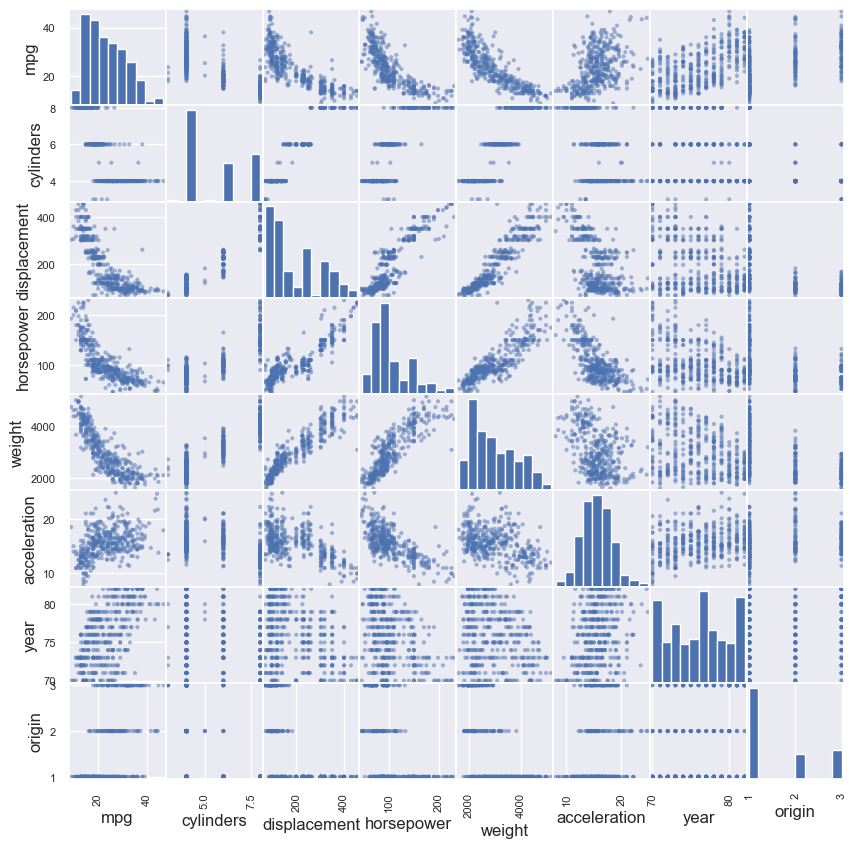

In [53]:
# 9(a)
pd.plotting.scatter_matrix(auto_df,figsize=(10,10))

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6'),
  Text(0, 7.0, '7'),
  Text(0, 8.0, '8')])

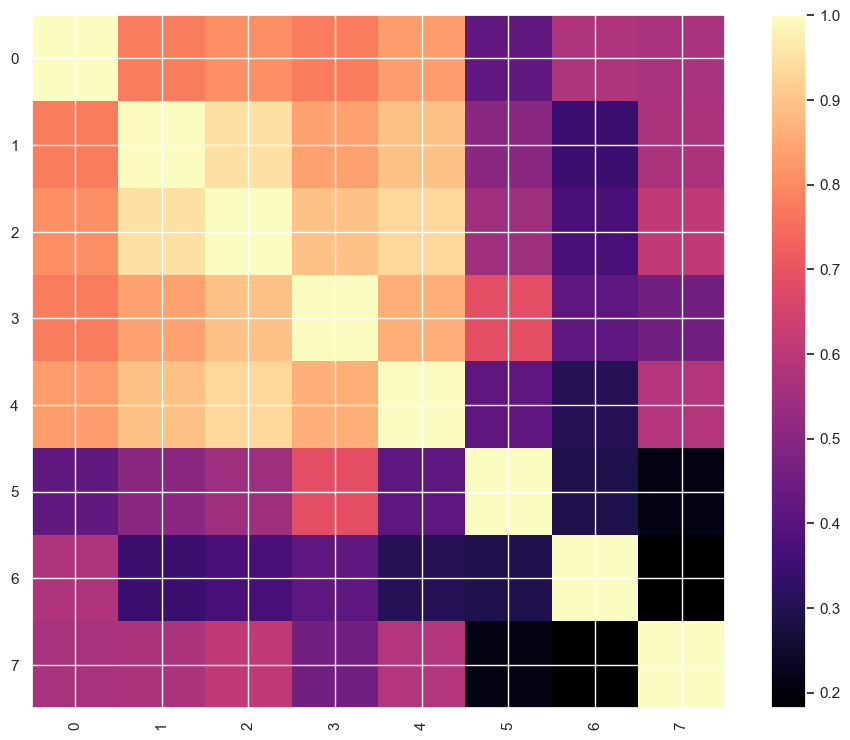

In [54]:
# 9(b)
auto_new = auto_df.drop('name',axis=1)
corr_matrix = auto_new.corr().abs()
f, ax = plt.subplots(figsize=(12, 9))
plt.imshow(corr_matrix,vmax=1,cmap="magma")
plt.colorbar()
plt.xticks(rotation=90)
plt.yticks(rotation=0)

In [55]:
# 9(c)
f = 'mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin)'
y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Wed, 17 Jul 2024   Prob (F-statistic):          1.79e-139
Time:                        13:27:44   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -17.9546      4.677     -3.

In [56]:
model.pvalues[model.pvalues < 0.05].sort_values()

year              2.332943e-40
weight            6.375633e-22
C(origin)[T.3]    3.933208e-07
C(origin)[T.2]    4.720373e-06
Intercept         1.445124e-04
displacement      1.862685e-03
dtype: float64

In [57]:
# Let's fit a model with all possible interaction effects

f = 'np.log1p(mpg) ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin) \
    + cylinders*displacement \
    + cylinders*horsepower \
    + cylinders*weight \
    + cylinders*acceleration \
    + cylinders*year \
    + displacement*horsepower \
    + displacement*weight \
    + displacement*acceleration \
    + displacement*year \
    + horsepower*weight \
    + horsepower*acceleration \
    + horsepower*year \
    + weight*weight \
    + weight*acceleration \
    + weight*year \
    + acceleration*year \
    '

y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log1p(mpg)   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     152.3
Date:                Wed, 17 Jul 2024   Prob (F-statistic):          2.31e-172
Time:                        13:27:45   Log-Likelihood:                 346.65
No. Observations:                 392   AIC:                            -645.3
Df Residuals:                     368   BIC:                            -550.0
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [58]:
# If we take p < 0.05 as our significance threshold
model.pvalues[model.pvalues < 0.05].sort_values()

cylinders:displacement    0.009575
acceleration              0.009944
acceleration:year         0.011091
displacement:year         0.017965
Intercept                 0.048352
dtype: float64

In [59]:
#Question 10 a)
# Load data
carseats = pd.read_csv('./Carseats.csv').drop('Unnamed: 0', axis=1)

# Pre-processing
# Convert quantitive datatypes to numerics
datatypes = {'quant': ['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education'],
             'qual': ['ShelveLoc', 'Urban', 'US']}
# Use floats for all quantitive values
quants = carseats[datatypes['quant']].astype(np.float_)
carseats_df = pd.concat([quants, carseats[datatypes['qual']]], axis=1)

carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc,Urban,US
0,9.50,138.0,73.0,11.0,276.0,120.0,42.0,17.0,Bad,Yes,Yes
1,11.22,111.0,48.0,16.0,260.0,83.0,65.0,10.0,Good,Yes,Yes
2,10.06,113.0,35.0,10.0,269.0,80.0,59.0,12.0,Medium,Yes,Yes
3,7.40,117.0,100.0,4.0,466.0,97.0,55.0,14.0,Medium,Yes,Yes
4,4.15,141.0,64.0,3.0,340.0,128.0,38.0,13.0,Bad,Yes,No


In [60]:
# Feature engineering
f = 'Sales ~ Price + C(Urban) + C(US)'
y, X = patsy.dmatrices(f, carseats_df, return_type='dataframe')

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

# Make predictions
y_pred = np.array(model.predict(X))

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           2.39e-23
Time:                        13:27:45   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          13.0435      0.651     

In [61]:
# Feature engineering
f = 'Sales ~ Price + C(US)'
y, X = patsy.dmatrices(f, carseats_df, return_type='dataframe')

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

# Make predictions
y_pred = np.array(model.predict(X))

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           2.66e-24
Time:                        13:27:45   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.0308      0.631     20.652   

In [62]:
def lm_stats(X, y, y_pred):
    """ LEVERAGE & STUDENTISED RESIDUALS
    - https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize
    """
    # Responses as np array vector
    try: 
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    # Residuals
    residuals = np.array(y - y_pred)
    
    # Hat matrix
    H = np.array(X @ np.linalg.inv(X.T @ X)) @ X.T
    
    # Leverage
    h_ii = np.diag(H)
    
    ## Externally studentised residual
    # In this case external studentisation is most appropriate 
    # because we are looking for outliers.
    
    # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)
    
    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)
    

    # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii, 
                         'studentised_residual': t,
                         'y_pred': y_pred})

In [63]:
def lm_plot(lm_stats_df): 
    """Provides R style residual plots based on results from lm_stat()"""
    # Parse stats
    t      = lm_stats_df['studentised_residual']
    h_ii   = lm_stats_df['leverage']
    y_pred = lm_stats_df['y_pred']
    
    # setup axis for grid
    plt.figure(1, figsize=(16, 18))
    
    # Studentised residual plot
    plt.subplot(321)
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual plot', fontweight='bold')
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color='r', linestyle='dashed')
    ax.axhline(y=-3, color='r', linestyle='dashed');
    
    # Normal Q-Q plot
    plt.subplot(322)
    ax = stats.probplot(t, dist='norm', plot=plt)
    plt.ylabel('Studentised residuals')
    plt.title('Normal Q-Q', fontweight='bold')
    
    # Standardised residuals
    plt.subplot(323)
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('√Standardized residuals')
    plt.title('Scale-Location', fontweight='bold')
    
    # Residuals vs Leverage plot
    plt.subplot(324)
    ax = sns.scatterplot(x=h_ii, y=t)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual vs Leverage', fontweight='bold');

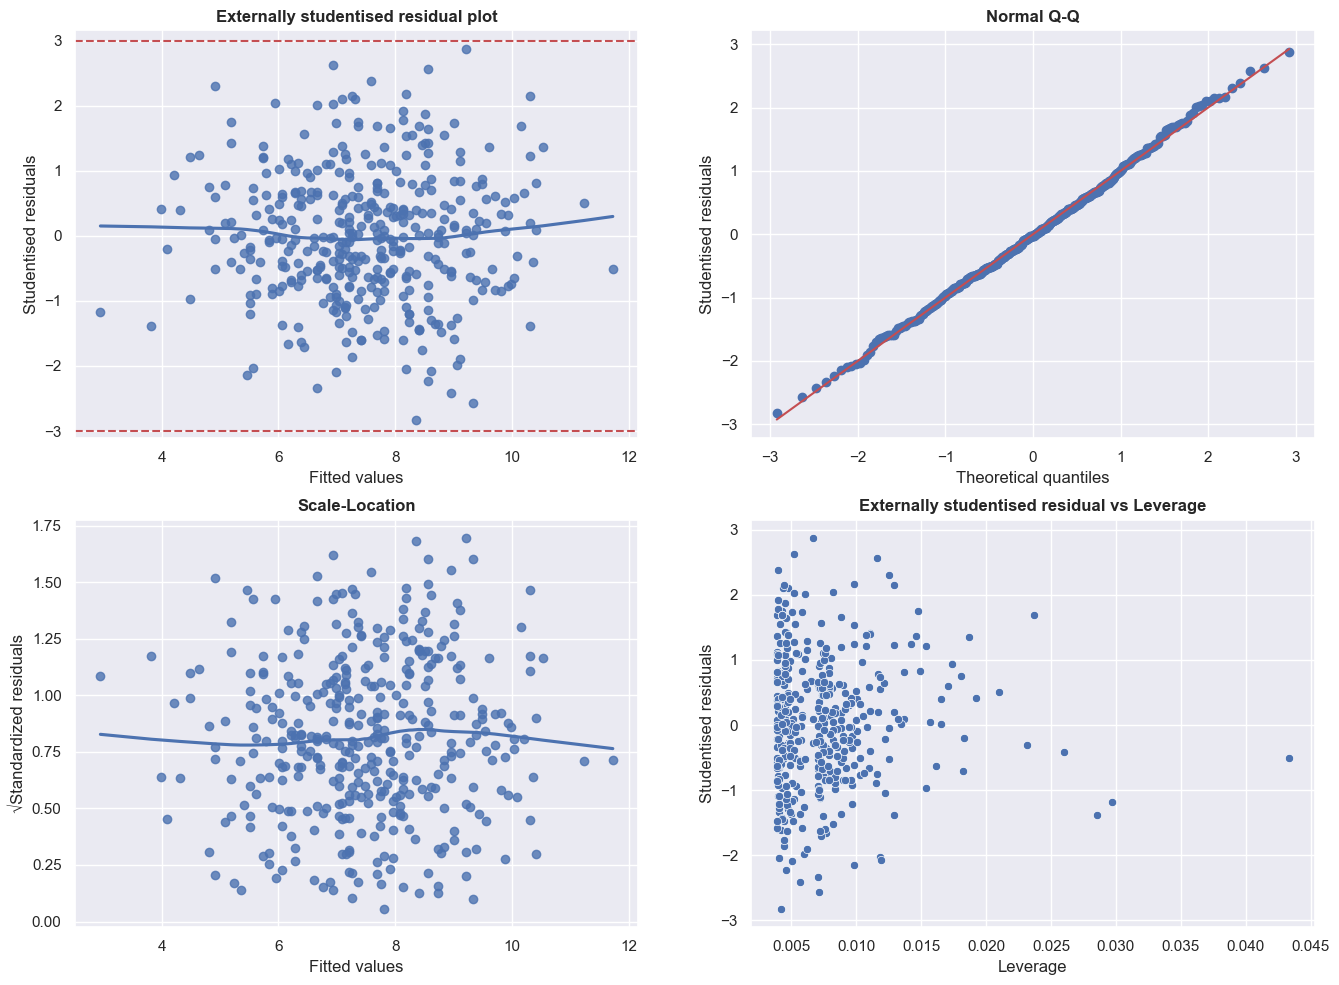

In [65]:
# Analyse residuals
lm_plot(lm_stats(X, y, y_pred))

In [70]:
# Extract 95% confidence intervals
conf_inter_95 = model.conf_int(alpha=0.05)
conf_inter_95
conf_inter_95.rename(index=str, columns={0: "min.", 1: "max.",})

,min.,max.
Intercept,11.79032,14.271265
C(US)[T.Yes],0.69152,1.707766
Price,-0.06476,-0.044195


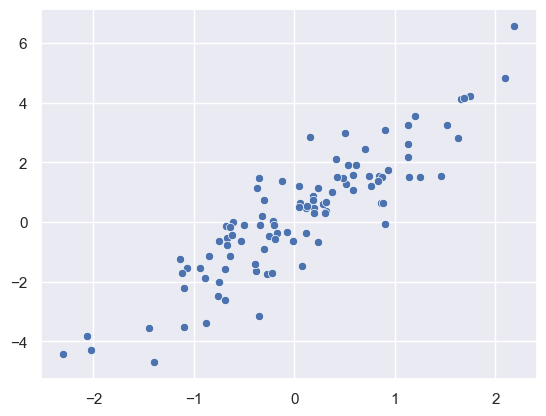

In [71]:
#11)
np.random.seed(1)
x  = np.random.normal(size=100)
y  = 2*x + np.random.normal(size=100)
df = pd.DataFrame({'x': x, 'y': y}) 
sns.scatterplot(x=x, y=y, color='b');

In [73]:
# Linear regression without intercept
f = 'y ~ x + 0'
y, X = patsy.dmatrices(f, df, return_type='dataframe')

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary(alpha=0.05))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.796
Method:                 Least Squares   F-statistic:                              391.7
Date:                Wed, 17 Jul 2024   Prob (F-statistic):                    3.46e-36
Time:                        13:34:02   Log-Likelihood:                         -135.67
No. Observations:                 100   AIC:                                      273.3
Df Residuals:                      99   BIC:                                      275.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [75]:
#the model slighly overestimates x which is supposed to be 2 but the model estimates it to be 2.1067
#b)
# Linear regression without intercept
f = 'x ~ y + 0'
y, X = patsy.dmatrices(f, df, return_type='dataframe')

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary(alpha=0.05))

                                 OLS Regression Results                                
Dep. Variable:                      x   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.796
Method:                 Least Squares   F-statistic:                              391.7
Date:                Wed, 17 Jul 2024   Prob (F-statistic):                    3.46e-36
Time:                        13:36:58   Log-Likelihood:                         -49.891
No. Observations:                 100   AIC:                                      101.8
Df Residuals:                      99   BIC:                                      104.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [76]:
'''
we know that y increases by 0.5 every unit increase in x. The model underestimates the coefficient predicting
0.3789
'''

'\nwe know that y increases by 0.5 every unit increase in x. The model underestimates the coefficient predicting\n0.3789\n'

In [78]:
# Fit model
model_a = smf.ols(formula='y ~ x', data=df).fit()
model_b = smf.ols(formula='x ~ y', data=df).fit()

print(model_a.tvalues)
print(model_b.tvalues)

Intercept     1.564347
x            19.782585
dtype: float64
Intercept    -1.089559
y            19.782585
dtype: float64


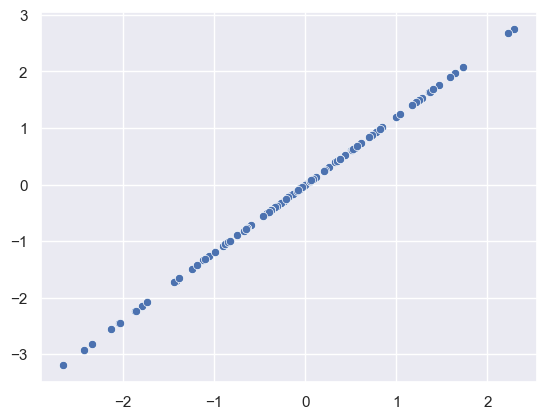

In [79]:
#12 b)
np.random.seed(2)
x = np.random.normal(size=100)
y = 1.2*x
df = pd.DataFrame({'x': x, 'y': y})
sns.scatterplot(x=x, y=y);

In [80]:
model_a = smf.ols(formula='y ~ x', data=df).fit()
model_b = smf.ols(formula='x ~ y', data=df).fit()

print(model_a.params)
print(model_b.params)

Intercept   -2.498002e-16
x            1.200000e+00
dtype: float64
Intercept   -2.775558e-17
y            8.333333e-01
dtype: float64


Intercept   -2.081668e-17
x            1.000000e+00
dtype: float64
Intercept   -2.081668e-17
y            1.000000e+00
dtype: float64


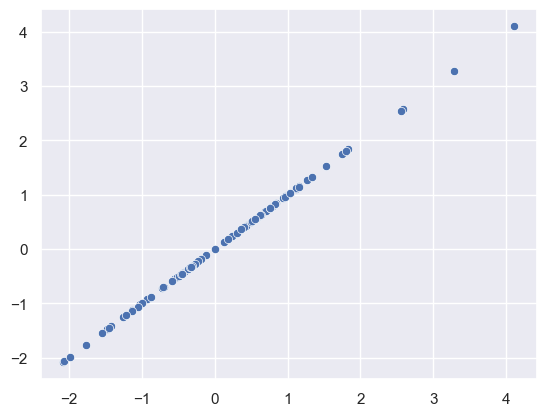

In [81]:
#c)
x = np.random.normal(size=100)
y = x
df = pd.DataFrame({'x': x, 'y': y})
sns.scatterplot(x=x, y=y);

model_a = smf.ols(formula='y ~ x', data=df).fit()
model_b = smf.ols(formula='x ~ y', data=df).fit()

print(model_a.params)
print(model_b.params)

In [82]:
#13 a)
np.random.seed(1)

mu, sigma = 0, 1
x = np.random.normal(mu, sigma, 100)

In [83]:
# b)
mu, sigma = 0, 0.25
eps = np.random.normal(mu, sigma, 100)

In [85]:
#c)
y = -1 + 0.5*x + eps
print('y length: ' + str(np.linalg.norm(y)))

y length: 10.660986158906173


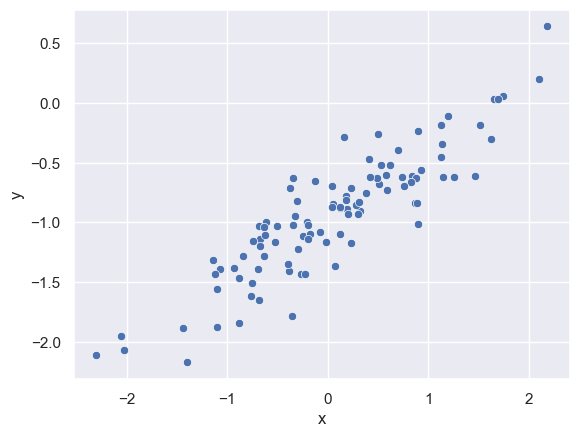

In [88]:
#d)
ax = sns.scatterplot(x=x, y=y)
plt.xlabel('x')
plt.ylabel('y');

In [89]:
#e)
model = smf.ols(formula='y ~ x', data=pd.DataFrame({'x':x, 'y':y})).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     391.4
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           5.39e-36
Time:                        14:27:23   Log-Likelihood:                 4.1908
No. Observations:                 100   AIC:                            -4.382
Df Residuals:                      98   BIC:                            0.8288
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9632      0.023    -40.999      0.0

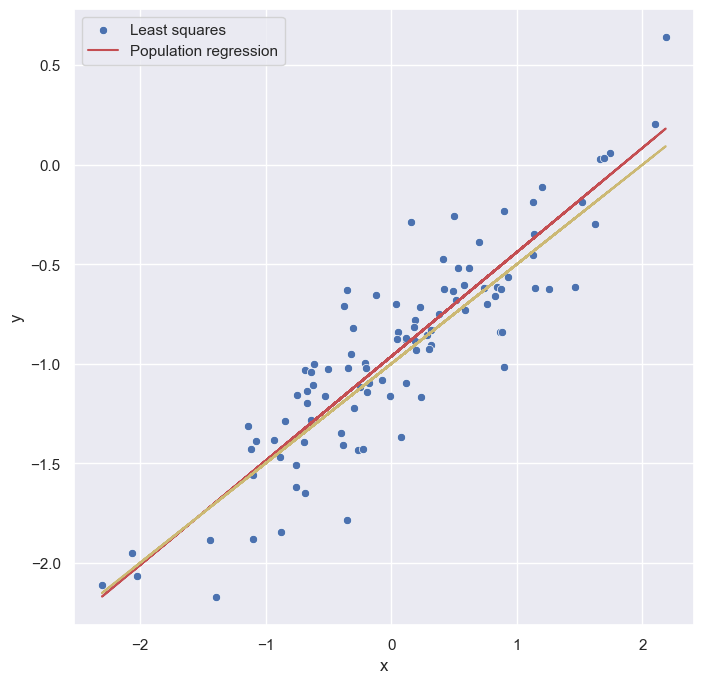

In [90]:
y_pred = model.predict()
y_act  = -1+(0.5*x)

plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x, y=y)
plt.xlabel('x')
plt.ylabel('y')
ax.plot(x, model.predict(), color='r')
ax.plot(x, -1+(0.5*x), color='y')
ax.legend(['Least squares', 'Population regression']);

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     193.8
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           1.32e-34
Time:                        14:29:03   Log-Likelihood:                 4.2077
No. Observations:                 100   AIC:                            -2.415
Df Residuals:                      97   BIC:                             5.400
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.9663      0.029    -33.486   

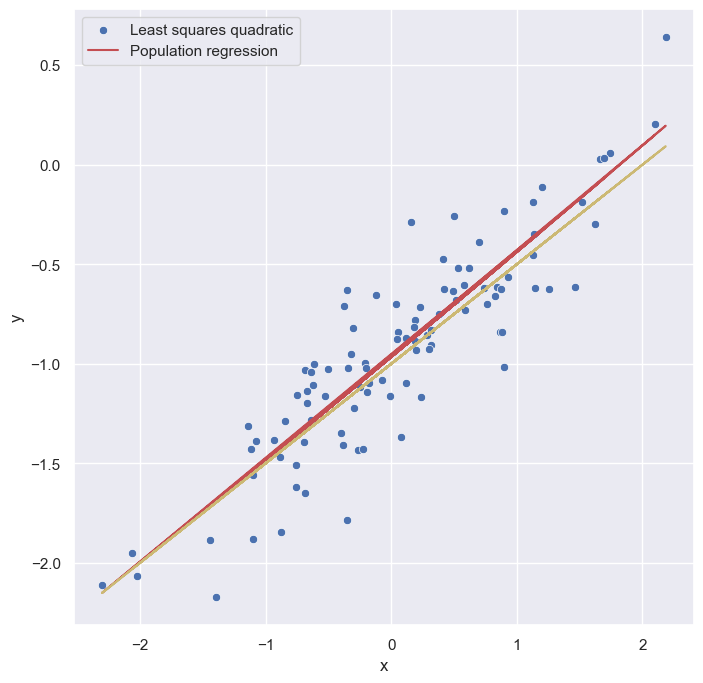

In [91]:
#g)
f = 'y ~ x + np.square(x)'
model = smf.ols(formula=f, data=pd.DataFrame({'x':x, 'y':y})).fit()
print(model.summary())

# predict
y_pred = model.predict()
y_act  = -1+(0.5*x)

# plot
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x, y=y)
plt.xlabel('x')
plt.ylabel('y')
ax.plot(x, model.predict(), color='r')
ax.plot(x, -1+(0.5*x), color='y')
ax.legend(['Least squares quadratic', 'Population regression']);

y length: 10.617729160380613
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     9084.
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           1.97e-98
Time:                        14:37:21   Log-Likelihood:                 165.13
No. Observations:                 100   AIC:                            -326.3
Df Residuals:                      98   BIC:                            -321.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9926  

,min.,max.
Intercept,-1.001974,-0.983325
x,0.494261,0.515281


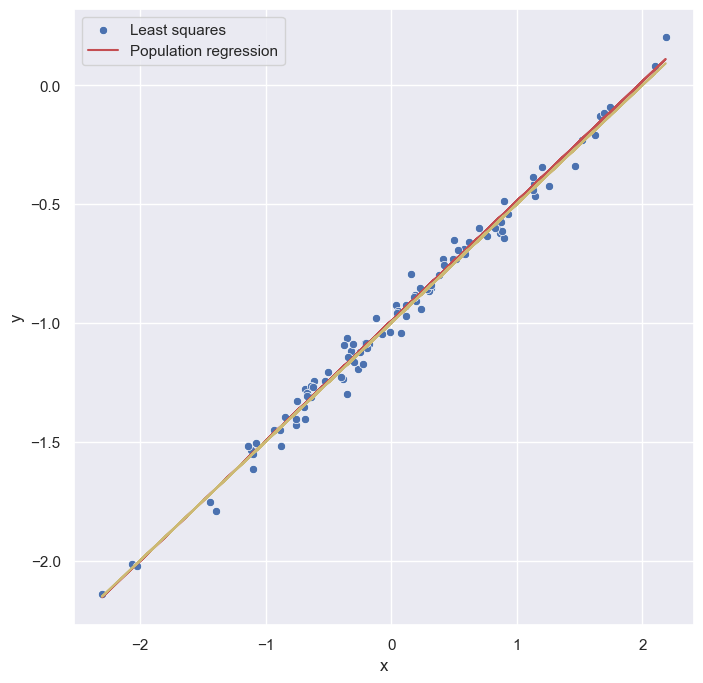

In [95]:
#h)
np.random.seed(1)

# generate x
mu, sigma = 0, 1
x = np.random.normal(mu, sigma, 100)

# generate epsilon
mu, sigma = 0, 0.05
eps = np.random.normal(mu, sigma, 100)

# generate y
y = -1 + 0.5*x + eps
print('y length: ' + str(np.linalg.norm(y)))

# Fit model
model = smf.ols(formula='y ~ x', data=pd.DataFrame({'x':x, 'y':y})).fit()
print(model.summary())

# Make predictions
y_pred = model.predict()
y_act  = -1+(0.5*x)

# Plot results
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x, y=y)
plt.xlabel('x')
plt.ylabel('y')
ax.plot(x, model.predict(), color='r')
ax.plot(x, -1+(0.5*x), color='y')
ax.legend(['Least squares', 'Population regression']);
conf_inter_95 = model.conf_int(alpha=0.05)
conf_inter_95
conf_inter_95.rename(index=str, columns={0: "min.", 1: "max.",})

y length: 11.173260452749581
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     107.0
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           2.20e-17
Time:                        14:37:33   Log-Likelihood:                -65.124
No. Observations:                 100   AIC:                             134.2
Df Residuals:                      98   BIC:                             139.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9265  

,min.,max.
Intercept,-1.019741,-0.833246
x,0.442613,0.652814


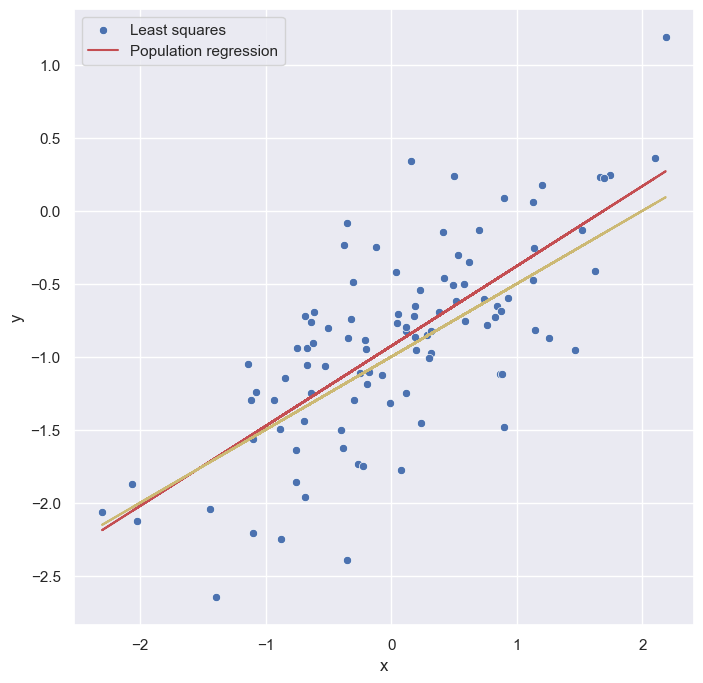

In [96]:
#i)
np.random.seed(1)

# generate x
mu, sigma = 0, 1
x = np.random.normal(mu, sigma, 100)

# generate epsilon
mu, sigma = 0, 0.5
eps = np.random.normal(mu, sigma, 100)

# generate y
y = -1 + 0.5*x + eps
print('y length: ' + str(np.linalg.norm(y)))

# Fit model
model = smf.ols(formula='y ~ x', data=pd.DataFrame({'x':x, 'y':y})).fit()
print(model.summary())

# Make predictions
y_pred = model.predict()
y_act  = -1+(0.5*x)

# Plot results
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x, y=y)
plt.xlabel('x')
plt.ylabel('y')
ax.plot(x, model.predict(), color='r')
ax.plot(x, -1+(0.5*x), color='y')
ax.legend(['Least squares', 'Population regression']);
conf_inter_95 = model.conf_int(alpha=0.05)
conf_inter_95
conf_inter_95.rename(index=str, columns={0: "min.", 1: "max.",})

In [98]:
#14 a)
# form is y = B0 + B1X1 + B2X2 + epsilon
np.random.seed(1)
x1 = np.random.uniform(size=100)
x2 = 0.5*x1 + np.random.randn(100)/10
y  = 2 + 2*x1 + 0.3*x2 + np.random.randn(100)

Correlation coefficient: 0.8390596222844917


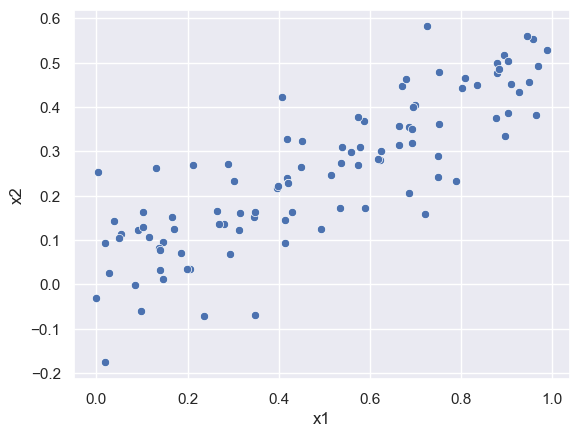

In [100]:
#b)
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
sns.scatterplot(x='x1', y='x2', data=df);

print('Correlation coefficient: ' + str(np.corrcoef(x1, x2)[0][1]))

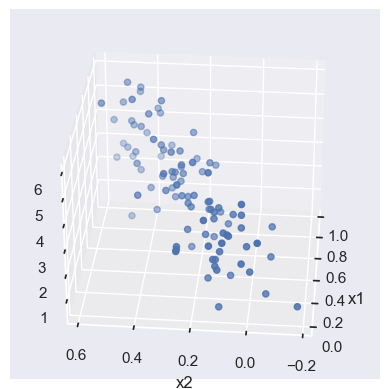

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     17.09
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           4.40e-07
Time:                        14:42:50   Log-Likelihood:                -142.34
No. Observations:                 100   AIC:                             290.7
Df Residuals:                      97   BIC:                             298.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1893      0.199     11.021      0.0

In [101]:
#c)
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x1'], df['x2'], df['y'])
ax.view_init(30, 185)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


# Fit model
f = 'y ~ x1 + x2'
model = smf.ols(formula=f, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     28.26
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           6.68e-07
Time:                        14:44:13   Log-Likelihood:                -144.76
No. Observations:                 100   AIC:                             293.5
Df Residuals:                      98   BIC:                             298.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2486      0.201     11.209      0.0

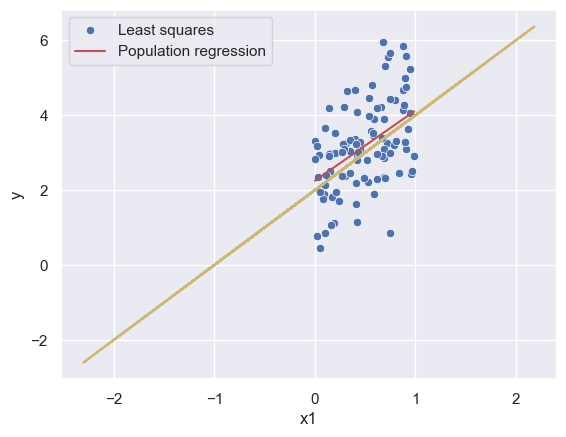

In [102]:
#d)
# Fit model
f = 'y ~ x1'
model = smf.ols(formula=f, data=df).fit()
print(model.summary())

df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
ax = sns.scatterplot(x='x1', y='y', data=df);
plt.xlabel('x1')
plt.ylabel('y')
ax.plot(df['x1'].sort_values(), model.predict(df['x1'].sort_values()), color='r')
ax.plot(x, 2+(2*x), color='y')
ax.legend(['Least squares', 'Population regression']);

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     32.87
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           1.09e-07
Time:                        14:46:02   Log-Likelihood:                -142.97
No. Observations:                 100   AIC:                             289.9
Df Residuals:                      98   BIC:                             295.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2655      0.187     12.145      0.0

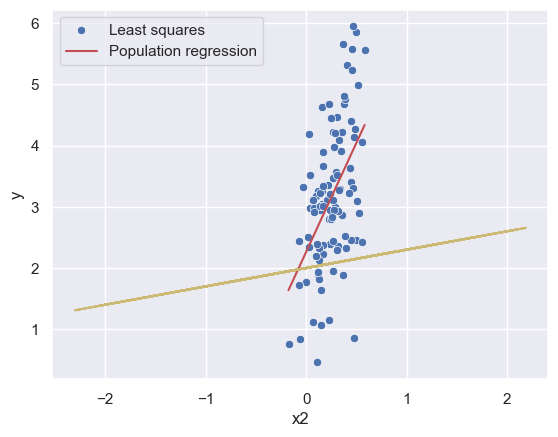

In [103]:
#e)
# Fit model
f = 'y ~ x2'
model = smf.ols(formula=f, data=df).fit()
print(model.summary())


df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
ax = sns.scatterplot(x='x2', y='y', data=df);
plt.xlabel('x2')
plt.ylabel('y')
ax.plot(df['x2'].sort_values(), model.predict(df['x2'].sort_values()), color='r')
ax.plot(x, 2+(0.3*x), color='y')
ax.legend(['Least squares', 'Population regression']);

In [105]:
#g)
x1 = np.concatenate([x1, [0.1]])
x2 = np.concatenate([x2, [0.8]])
y = np.concatenate([y, [6]])

df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})

# Fit models
model_c = smf.ols(formula='y ~ x1 + x2', data=df).fit()
model_d = smf.ols(formula='y ~ x1', data=df).fit()
model_e = smf.ols(formula='y ~ x2', data=df).fit()

In [106]:
model_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     19.92
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           5.51e-08
Time:                        14:51:38   Log-Likelihood:                -144.15
No. Observations:                 101   AIC:                             294.3
Df Residuals:                      98   BIC:                             302.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1996      0.199     11.041      0.000       1.804       2.595
x1             0.2200      0.520      0.423      0.673      -0.812       1.252
x2             3.4392      0.892      3.857      0.000       1.670       5.209
==============================================================================
Omnibus:                        1.246   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.536   Jarque-Bera (JB):                1.094
Skew:                          -0.254   Prob(JB):                        0.579
Kurtosis:                       2.956   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
model_d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     21.89
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           9.15e-06
Time:                        14:51:59   Log-Likelihood:                -151.28
No. Observations:                 101   AIC:                             306.6
Df Residuals:                      99   BIC:                             311.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3583      0.208     11.331      0.000       1.945       2.771
x1             1.7225      0.368      4.679      0.000       0.992       2.453
==============================================================================
Omnibus:                        1.904   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.386   Jarque-Bera (JB):                1.388
Skew:                           0.263   Prob(JB):                        0.500
Kurtosis:                       3.232   Cond. No.                         4.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
model_e.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     39.99
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           7.41e-09
Time:                        14:52:02   Log-Likelihood:                -144.24
No. Observations:                 101   AIC:                             292.5
Df Residuals:                      99   BIC:                             297.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2331      0.182     12.271      0.000       1.872       2.594
x2             3.7216      0.589      6.324      0.000       2.554       4.889
==============================================================================
Omnibus:                        1.271   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                1.094
Skew:                          -0.255   Prob(JB):                        0.579
Kurtosis:                       2.973   Cond. No.                         6.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
'''this anomaly has increased model c's p value for B1 suggesting even more strongly the false acceptance of the null
hypothesis. When considered separately the estimates for B1 and B2 are worse when this anomaly is introduced.
'''

"this anomaly has increased model c's p value for B1 suggesting even more strongly the false acceptance of the null\nhypothesis. When considered separately the estimates for B1 and B2 are worse when this anomaly is introduced.\n"

In [119]:
boston = load_data("Boston")
boston_df = pd.DataFrame(boston, columns=boston.columns)

# Check for missing values
assert boston_df.isnull().sum().sum() == 0

models_a = [smf.ols(formula='crim ~ {}'.format(f), data=boston_df).fit()
            for f in boston_df.columns[1:]]

for model in models_a:
    dp = 4
    display(pd.DataFrame({'coef':    np.around(model.params, dp),
                          'std_err': np.around(model.bse, dp),
                          't':       np.around(model.params / model.bse, dp),
                          'P>|t|':   np.around(model.pvalues, dp),
                          '[0.025':  np.around(model.conf_int(alpha=0.05)[0], dp),
                          '0.975]':  np.around(model.conf_int(alpha=0.05)[1], dp)}))

,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,4.4537,0.4172,10.6747,0.0,3.6340,5.2734
zn,-0.0739,0.0161,-4.5938,0.0,-0.1056,-0.0423


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-2.0637,0.6672,-3.0930,0.0021,-3.3746,-0.7529
indus,0.5098,0.0510,9.9908,0.0000,0.4095,0.6100


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,3.7444,0.3961,9.4530,0.0000,2.9662,4.5227
chas,-1.8928,1.5061,-1.2567,0.2094,-4.8518,1.0663


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-13.7199,1.6995,-8.073,0.0,-17.0588,-10.3809
nox,31.2485,2.9992,10.419,0.0,25.3561,37.1410


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,20.4818,3.3645,6.0877,0.0,13.8717,27.0919
rm,-2.6841,0.5320,-5.0448,0.0,-3.7293,-1.6388


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-3.7779,0.9440,-4.0021,0.0001,-5.6325,-1.9233
age,0.1078,0.0127,8.4628,0.0000,0.0828,0.1328


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,9.4993,0.7304,13.0056,0.0,8.0643,10.9343
dis,-1.5509,0.1683,-9.2135,0.0,-1.8816,-1.2202


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-2.2872,0.4435,-5.1573,0.0,-3.1584,-1.4159
rad,0.6179,0.0343,17.9982,0.0,0.5505,0.6854


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-8.5284,0.8158,-10.4539,0.0,-10.1312,-6.9256
tax,0.0297,0.0018,16.0994,0.0,0.0261,0.0334


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-17.6469,3.1473,-5.6071,0.0,-23.8303,-11.4635
ptratio,1.1520,0.1694,6.8014,0.0,0.8192,1.4847


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-3.3305,0.6938,-4.8007,0.0,-4.6936,-1.9675
lstat,0.5488,0.0478,11.4907,0.0,0.4550,0.6426


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,11.7965,0.9342,12.6276,0.0,9.9612,13.6319
medv,-0.3632,0.0384,-9.4597,0.0,-0.4386,-0.2877


In [125]:
for model in models_a:
    if model.pvalues[1] < 0.05:
        print(model.params[1:].index[0])

zn
indus
nox
rm
age
dis
rad
tax
ptratio
lstat
medv


C:\Users\Christian VanMeter\AppData\Local\Temp\ipykernel_23804\2930504724.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if model.pvalues[1] < 0.05:


In [126]:
for model in models_a:
    if model.pvalues[1] > 0.05:
        print(model.params[1:].index[0])

chas


C:\Users\Christian VanMeter\AppData\Local\Temp\ipykernel_23804\2021750761.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if model.pvalues[1] > 0.05:


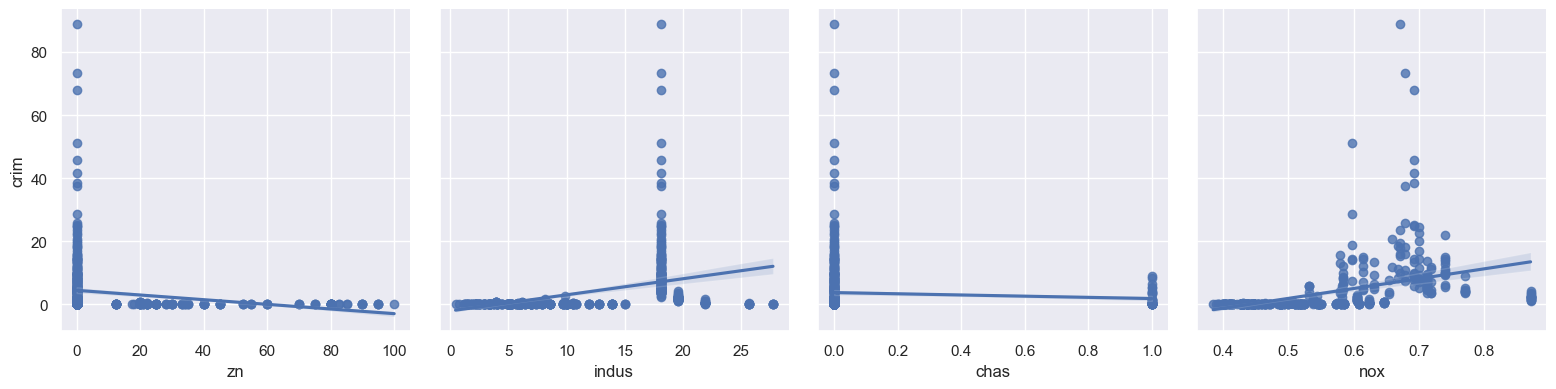

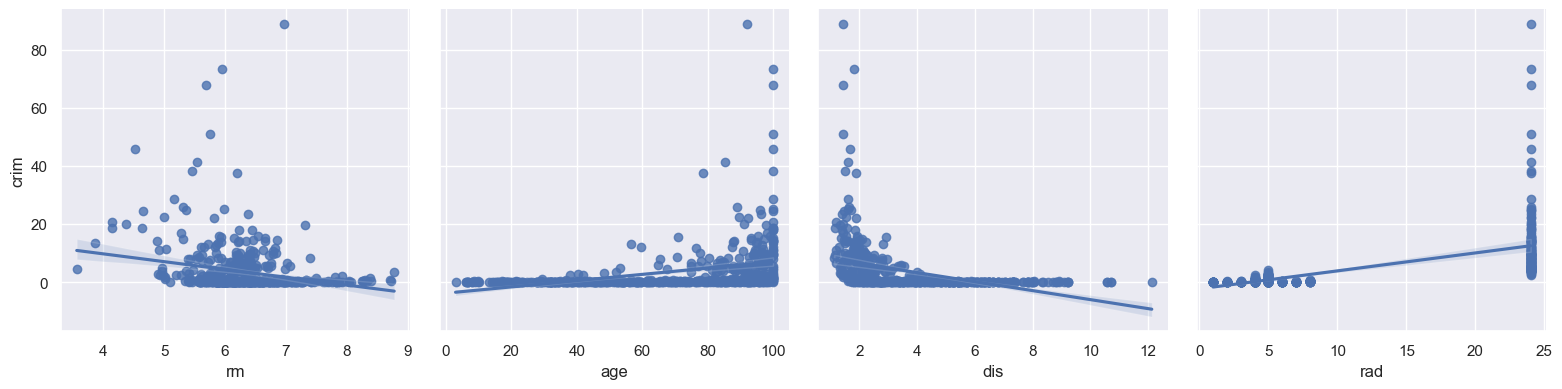

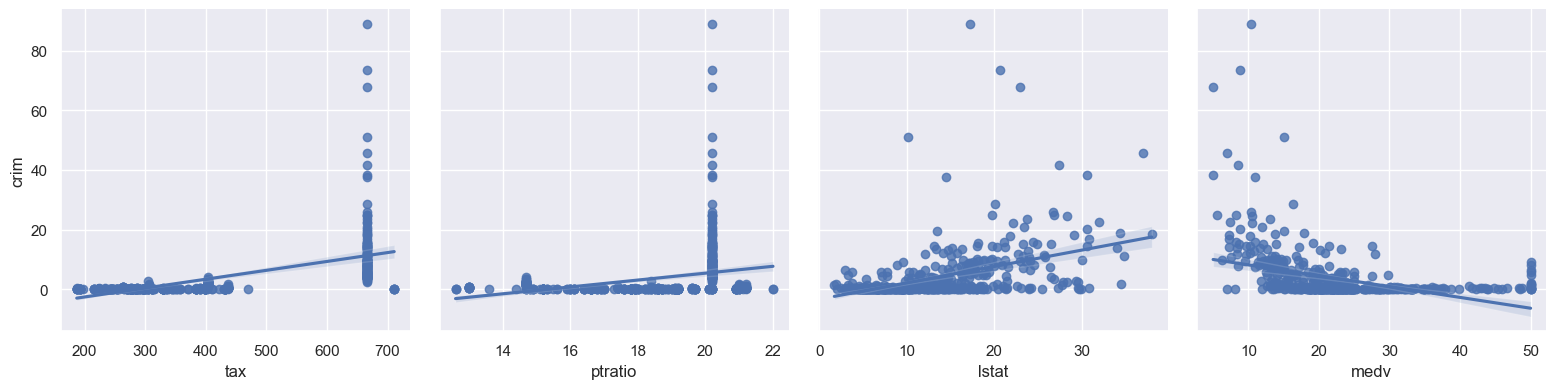

In [129]:
#Create some plots to back up yassertions
def plot_grid(df, response, cols):
    """ Plot all predictor variables against response in grid """
    variables = df.columns.drop(response)
    for i in range(0, len(variables), cols):
        g = sns.PairGrid(df, y_vars=[response], x_vars=variables[i:i+cols], height=4)
        g.map(sns.regplot);
    return

plot_grid(boston_df, 'crim', 4)

In [130]:
#b)
response   = 'crim'
predictors = boston_df.columns.drop(response)
f = '{} ~ {}'.format(response, '+'.join(predictors))

model_b = smf.ols(formula=f, data=boston_df).fit()
model_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   crim   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     33.52
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           2.03e-56
Time:                        15:08:21   Log-Likelihood:                -1655.4
No. Observations:                 506   AIC:                             3337.
Df Residuals:                     493   BIC:                             3392.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.7784      7.082      1.946      0.052      -0.136      27.693
zn             0.0457      0.019      2.433      0.015       0.009       0.083
indus         -0.0584      0.084     -0.698      0.486      -0.223       0.106
chas          -0.8254      1.183     -0.697      0.486      -3.150       1.500
nox           -9.9576      5.290     -1.882      0.060     -20.351       0.436
rm             0.6289      0.607      1.036      0.301      -0.564       1.822
age           -0.0008      0.018     -0.047      0.962      -0.036       0.034
dis           -1.0122      0.282     -3.584      0.000      -1.567      -0.457
rad            0.6125      0.088      6.997      0.000       0.440       0.784
tax           -0.0038      0.005     -0.730      0.466      -0.014       0.006
ptratio       -0.3041      0.186     -1.632      0.103      -0.670       0.062
lstat          0.1388      0.076      1.833      0.067      -0.010       0.288
medv          -0.2201      0.060     -3.678      0.000      -0.338      -0.103
==============================================================================
Omnibus:                      663.436   Durbin-Watson:                   1.516
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80856.852
Skew:                           6.579   Prob(JB):                         0.00
Kurtosis:                      63.514   Cond. No.                     1.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [131]:
display(HTML('<h3>p < 0.05</h3>'))
model_b.pvalues[model_b.pvalues < 0.05]

zn      1.534403e-02
dis     3.725942e-04
rad     8.588123e-12
medv    2.605302e-04
dtype: float64

,Univariate_coef,Multivariate_coef
zn,-0.073935,0.045710
indus,0.509776,-0.058350
chas,-1.892777,-0.825378
nox,31.248531,-9.957587
rm,-2.684051,0.628911
age,0.107786,-0.000848
dis,-1.550902,-1.012247
rad,0.617911,0.612465
tax,0.029742,-0.003776
ptratio,1.151983,-0.304073


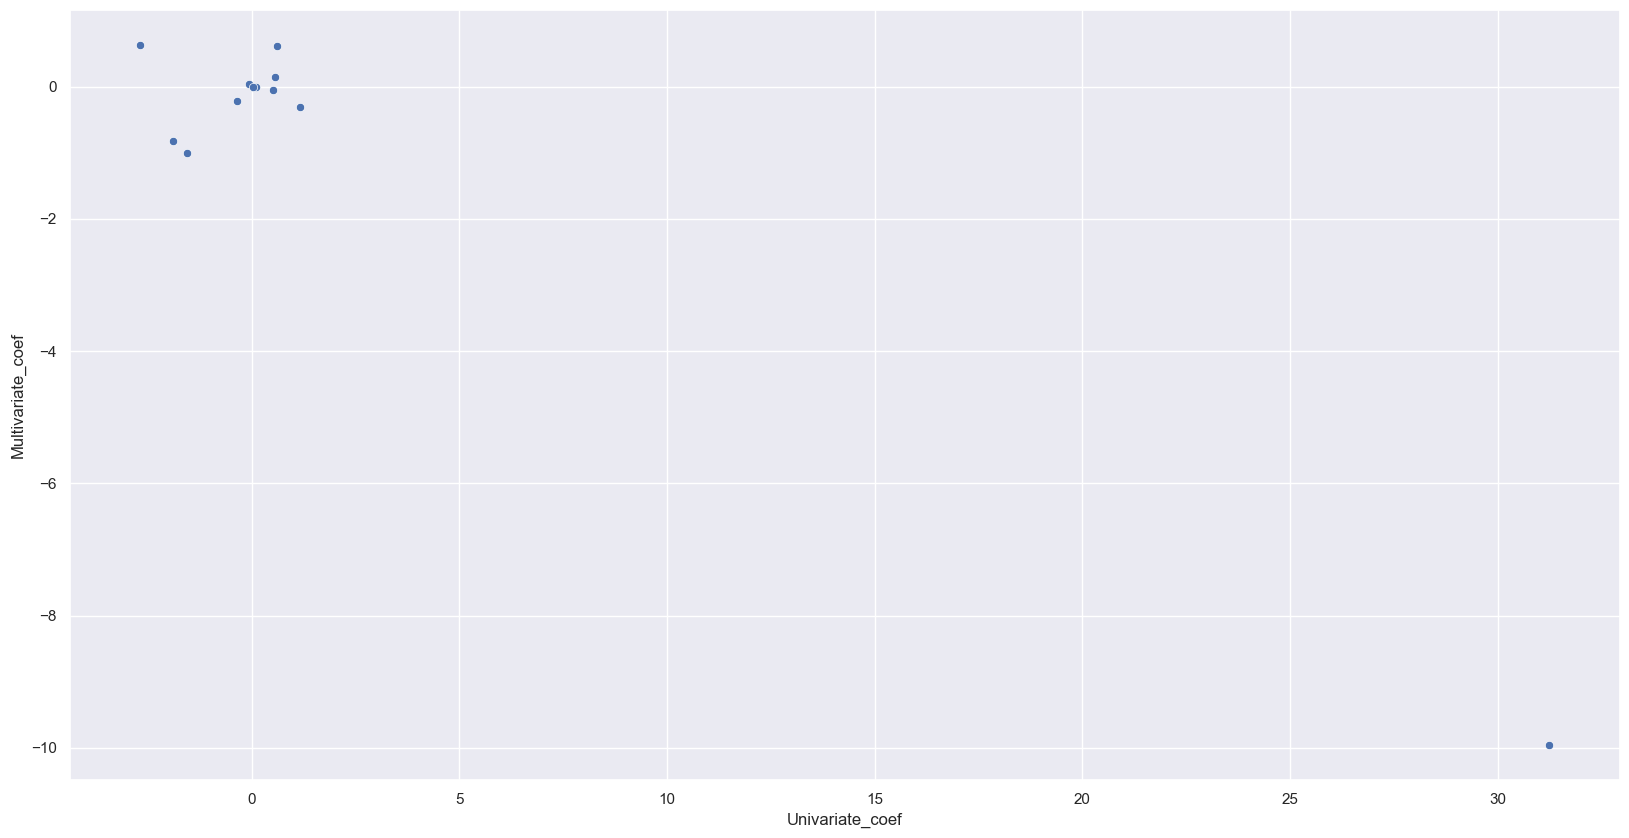

In [133]:
#c)
# Get coefficients
univariate_params = pd.concat([m.params[1:] for m in models_a])
multivariate_params = model_b.params[1:]
df = pd.DataFrame({'Univariate_coef': univariate_params, 
                   'Multivariate_coef': multivariate_params,})
display(df)

plt.figure(figsize=(20,10))
ax = sns.scatterplot(x='Univariate_coef', y='Multivariate_coef', data=df);

In [134]:
#d)
models_d = [smf.ols(formula='crim ~ {0} + np.power({0}, 2) + np.power({0}, 3)'.format(f), data=boston_df).fit()
            for f in boston_df.columns[1:]]

for model in models_d:
    dp = 4
    display(pd.DataFrame({'coef':    np.around(model.params, dp),
                          'std_err': np.around(model.bse, dp),
                          't':       np.around(model.params / model.bse, dp),
                          'P>|t|':   np.around(model.pvalues, dp),
                          '[0.025':  np.around(model.conf_int(alpha=0.05)[0], dp),
                          '0.975]':  np.around(model.conf_int(alpha=0.05)[1], dp)}))

,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,4.8461,0.4330,11.1922,0.0000,3.9954,5.6967
zn,-0.3322,0.1098,-3.0252,0.0026,-0.5479,-0.1164
"np.power(zn, 2)",0.0065,0.0039,1.6791,0.0938,-0.0011,0.0141
"np.power(zn, 3)",-0.0000,0.0000,-1.2030,0.2295,-0.0001,0.0000


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,3.6626,1.5740,2.3269,0.0204,0.5702,6.7550
indus,-1.9652,0.4820,-4.0773,0.0001,-2.9122,-1.0182
"np.power(indus, 2)",0.2519,0.0393,6.4070,0.0000,0.1747,0.3292
"np.power(indus, 3)",-0.0070,0.0010,-7.2920,0.0000,-0.0089,-0.0051


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,3.744400e+00,3.965000e-01,9.4436,0.0000,2.965400e+00,4.523500e+00
chas,1.114140e+14,2.711568e+14,0.4109,0.6813,-4.213255e+14,6.441534e+14
"np.power(chas, 2)",-5.609613e+13,1.365255e+14,-0.4109,0.6813,-3.243266e+14,2.121343e+14
"np.power(chas, 3)",-5.531784e+13,1.346313e+14,-0.4109,0.6813,-3.198268e+14,2.091911e+14


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,233.0866,33.6431,6.9282,0.0,166.9880,299.1852
nox,-1279.3713,170.3975,-7.5082,0.0,-1614.1513,-944.5912
"np.power(nox, 2)",2248.5441,279.8993,8.0334,0.0,1698.6257,2798.4624
"np.power(nox, 3)",-1245.7029,149.2816,-8.3446,0.0,-1538.9966,-952.4091


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,112.6246,64.5172,1.7457,0.0815,-14.1325,239.3817
rm,-39.1501,31.3115,-1.2503,0.2118,-100.6679,22.3676
"np.power(rm, 2)",4.5509,5.0099,0.9084,0.3641,-5.2920,14.3938
"np.power(rm, 3)",-0.1745,0.2637,-0.6615,0.5086,-0.6927,0.3437


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-2.5488,2.7691,-0.9204,0.3578,-7.9893,2.8918
age,0.2737,0.1864,1.4683,0.1427,-0.0925,0.6398
"np.power(age, 2)",-0.0072,0.0036,-1.9878,0.0474,-0.0144,-0.0001
"np.power(age, 3)",0.0001,0.0000,2.7237,0.0067,0.0000,0.0001


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,30.0476,2.4459,12.2850,0.0,25.2422,34.8530
dis,-15.5544,1.7360,-8.9600,0.0,-18.9650,-12.1437
"np.power(dis, 2)",2.4521,0.3464,7.0783,0.0,1.7715,3.1327
"np.power(dis, 3)",-0.1186,0.0204,-5.8135,0.0,-0.1587,-0.0785


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-0.6055,2.0501,-0.2954,0.7678,-4.6334,3.4223
rad,0.5127,1.0436,0.4913,0.6234,-1.5376,2.5631
"np.power(rad, 2)",-0.0752,0.1485,-0.5061,0.6130,-0.3670,0.2167
"np.power(rad, 3)",0.0032,0.0046,0.7031,0.4823,-0.0058,0.0122


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,19.1836,11.7955,1.6263,0.1045,-3.9911,42.3583
tax,-0.1533,0.0957,-1.6023,0.1097,-0.3413,0.0347
"np.power(tax, 2)",0.0004,0.0002,1.4877,0.1375,-0.0001,0.0008
"np.power(tax, 3)",-0.0000,0.0000,-1.1668,0.2439,-0.0000,0.0000


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,477.1840,156.7950,3.0434,0.0025,169.1288,785.2393
ptratio,-82.3605,27.6439,-2.9793,0.0030,-136.6726,-28.0485
"np.power(ptratio, 2)",4.6353,1.6083,2.8821,0.0041,1.4755,7.7952
"np.power(ptratio, 3)",-0.0848,0.0309,-2.7433,0.0063,-0.1455,-0.0241


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,1.2010,2.0286,0.5920,0.5541,-2.7847,5.1866
lstat,-0.4491,0.4649,-0.9660,0.3345,-1.3624,0.4643
"np.power(lstat, 2)",0.0558,0.0301,1.8522,0.0646,-0.0034,0.1149
"np.power(lstat, 3)",-0.0009,0.0006,-1.5170,0.1299,-0.0020,0.0003


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,53.1655,3.3563,15.8405,0.0,46.5714,59.7597
medv,-5.0948,0.4338,-11.7438,0.0,-5.9472,-4.2425
"np.power(medv, 2)",0.1555,0.0172,9.0455,0.0,0.1217,0.1893
"np.power(medv, 3)",-0.0015,0.0002,-7.3120,0.0,-0.0019,-0.0011


In [135]:
display(HTML('<h3>Features with p < 0.05</h3>'))

sig = pd.concat([model.pvalues[model.pvalues < 0.05] for model in models_d])

display(pd.DataFrame({'P>|t|':sig.drop('Intercept')}))

,P>|t|
zn,2.612296e-03
indus,5.297064e-05
"np.power(indus, 2)",3.420187e-10
"np.power(indus, 3)",1.196405e-12
nox,2.758372e-13
"np.power(nox, 2)",6.811300e-15
"np.power(nox, 3)",6.961110e-16
"np.power(age, 2)",4.737733e-02
"np.power(age, 3)",6.679915e-03
dis,6.374792e-18
